<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# ARIMA: Autoregressive Integrated Moving Average

This notebook provides an example of how to train an ARIMA model to generate point forecasts of product sales in retail. We will train an ARIMA based model on the Orange Juice dataset.

An ARIMA, which stands for AutoRegressive Integrated Moving Average, model can be created using an `ARIMA(p,d,q)` model within `statsmodels` library. In this notebook, we will be using an alternative library `pmdarima`, which allows us to automatically search for optimal ARIMA parameters, within a specified range. More specifically, we will be using `auto_arima` function within `pmdarima` to automatically discover the optimal parameters for an ARIMA model. This function wraps `ARIMA` and `SARIMAX` models of `statsmodels` library, that correspond to non-seasonal and seasonal model space, respectively.

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:
- **p** is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
- **d** is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- **q** is the parameter associated with the moving average part of the model.,

If our data has a seasonal component, we use a seasonal ARIMA model or `ARIMA(p,d,q)(P,D,Q)m`. In that case, we have an additional set of parameters: `P`, `D`, and `Q` which describe the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model, and `m` refers to the number of periods in each season.


## Global Settings and Imports

In [1]:
import os
import sys
import math
import warnings
import itertools
import numpy as np
import pandas as pd
import scrapbook as sb
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima

from fclib.common.utils import git_repo_path, module_exists
from fclib.common.plot import plot_predictions_with_history
from fclib.evaluation.evaluation_utils import MAPE
from fclib.dataset.ojdata import download_ojdata, split_train_test, complete_and_fill_df

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))

System version: 3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 23:13:11) 
[GCC 7.3.0]


## Parameters

Next, we define global settings related to the model. We will use historical weekly sales data only, without any covariate features to train the ARIMA model. The model parameter ranges are provided in params. These are later used by the `auto_arima()` function to search the space for the optimal set of parameters. To increase the space of models to search over, increase the `max_p` and `max_q` parameters.

> NOTE: Our data does not show a strong seasonal component (as demonstrated in data exploration example notebook), so we will not be searching over the seasonal ARIMA models. To search over the seasonal models, set `seasonal` to `True` and include `start_P`, `start_Q`, `max_P`, and `max_Q` parameters in the auto_arima() function.

In [2]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = True

# Data directory
DATA_DIR = os.path.join(git_repo_path(), "ojdata")

# Forecasting settings
N_SPLITS = 1
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 138

# Parameters of ARIMA model
params = {
    "seasonal": False,
    "start_p": 0,
    "start_q": 0,
    "max_p": 5,
    "max_q": 5,
    "m": 52,
}

# If True, run notebook on a subset of stores (to reduce the run time)
STORE_SUBSET = False

## Data Preparation

We need to download the Orange Juice data and split it into training and test sets. By default, the following cell will download and spit the data. If you've already done so, you may skip this part by switching `DOWNLOAD_SPLIT_DATA` to `False`.

We store the training data and test data using dataframes. The training data includes `train_df` and `aux_df` with `train_df` containing the historical sales up to week 135 (the time we make forecasts) and `aux_df` containing price/promotion information up until week 138. Here we assume that future price and promotion information up to a certain number of weeks ahead is predetermined and known. In our example, we will be using historical sales only, and will not be using the `aux_df` data. The test data is stored in `test_df` which contains the sales of each product in week 137 and 138. Assuming the current week is week 135, our goal is to forecast the sales in week 137 and 138 using the training data. There is a one-week gap between the current week and the first target week of forecasting as we want to leave time for planning inventory in practice.

The setting of the forecast problem are defined in `fclib.dataset.ojdata.split_train_test` function. We can change this setting (e.g., modify the horizon of the forecast or the range of the historical data) by passing different parameters to this functions. Below, we split the data into `n_splits=1` splits, using the forecasting settings listed above in the **Parameters** section.

In [3]:
if DOWNLOAD_SPLIT_DATA:
    download_ojdata(DATA_DIR)
    train_df_list, test_df_list, _ = split_train_test(
        DATA_DIR,
        n_splits=N_SPLITS,
        horizon=HORIZON,
        gap=GAP,
        first_week=FIRST_WEEK,
        last_week=LAST_WEEK,
        write_csv=True,
    )

    # Split returns a list, extract the dataframes from the list
    train_df = train_df_list[0].reset_index()
    test_df = test_df_list[0].reset_index()

Data already exists at the specified location.


### Process training data

Our time series data is not complete, since we have missing sales for some stores/products and weeks. We will fill in those missing values by propagating the last valid observation forward to next available value. We will define functions for data frame processing, then use these functions within a loop that loops over each forecasting rounds.

Note that our time series are grouped by `store` and `brand`, while `week` represents a time step, and `logmove` represents the value to predict.

Let's first process the training data. Note that the training data runs from `FIRST_WEEK` to `LAST_WEEK - HORIZON - GAP + 1` as defined in Parameters section above.

In [4]:
# Select only required columns
train_df = train_df[["store", "brand", "week", "logmove"]]
train_df.head(10)

,store,brand,week,logmove
0,2,1,40,9.02
1,2,1,46,8.72
2,2,1,47,8.25
3,2,1,48,8.99
4,2,1,50,9.09
5,2,1,51,8.88
6,2,1,52,9.29
7,2,1,53,8.95
8,2,1,54,9.05
9,2,1,57,8.61


Notice that the unit sales of the products are given in logarithmic scale. We will use this quantity for training the forecasting model, as it smooths out the time series, and results in better forecasting performance. We will convert the `logmove` to a unit scale for evaluation, for consistency across our examples.

In [5]:
# Create a dataframe to hold all necessary data
store_list = train_df["store"].unique()
brand_list = train_df["brand"].unique()
train_week_list = range(FIRST_WEEK, LAST_WEEK - (HORIZON - 1) - (GAP - 1))

train_filled = complete_and_fill_df(train_df, stores=store_list, brands=brand_list, weeks=train_week_list)

train_filled.head(10)

,store,brand,week,logmove
0,2,1,40,9.02
1,2,1,41,9.02
2,2,1,42,9.02
3,2,1,43,9.02
4,2,1,44,9.02
5,2,1,45,9.02
6,2,1,46,8.72
7,2,1,47,8.25
8,2,1,48,8.99
9,2,1,49,8.99


### Process test data

Let's now process the test data. Note that the test data runs from `LAST_WEEK - HORIZON + 1` to `LAST_WEEK`. Note that, in addition to filling out missing values, we also convert unit sales from logarithmic scale to the counts. We will do model training on the log scale, due to improved performance, however, we will transfrom the test data back into the unit scale (counts) by applying `math.exp()`, so that we can evaluate the performance on the unit scale.

In [6]:
# Evaluate prediction accuracy
test_df["actuals"] = test_df.logmove.apply(lambda x: round(math.exp(x)))
test_df = test_df[["store", "brand", "week", "actuals"]]

test_week_list = range(LAST_WEEK - HORIZON + 1, LAST_WEEK + 1)
test_filled = complete_and_fill_df(test_df, stores=store_list, brands=brand_list, weeks=test_week_list)

test_filled.head(10)

,store,brand,week,actuals
0,2,1,137,9792
1,2,1,138,16960
2,2,2,137,6240
3,2,2,138,14784
4,2,3,137,1920
5,2,3,138,1408
6,2,4,137,1984
7,2,4,138,10944
8,2,5,137,19008
9,2,5,138,3904


## Model training

We next train an ARIMA model for a single time series, for demonstration. We select `STORE=2` and `BRAND=6` and filter our data based on these values.

In [7]:
STORE = 2
BRAND = 6

train_ts = train_filled.loc[(train_filled.store == STORE) & (train_filled.brand == BRAND)]
train_ts.tail(10)

,store,brand,week,logmove
566,2,6,126,8.52
567,2,6,127,8.03
568,2,6,128,8.15
569,2,6,129,8.03
570,2,6,130,7.74
571,2,6,131,7.45
572,2,6,132,7.70
573,2,6,133,7.93
574,2,6,134,7.27
575,2,6,135,6.96


In [8]:
train_ts = np.array(train_ts.logmove)

model = auto_arima(
    train_ts,
    seasonal=params["seasonal"],
    start_p=params["start_p"],
    start_q=params["start_q"],
    max_p=params["max_p"],
    max_q=params["max_q"],
    stepwise=True,
)

model.fit(train_ts)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

Let's look at the model summary. As seen from the summary, the selected ARIMA model is `(p=1, d=0, q=0)`. This is a relatively simple model, also referred to as first-order auto-regressive model. It indicates that the time series is stationary and can be predicted as a multiple of its own previous value, plus a constant.  This is an `ARIMA(1,0,0)+constant` model.

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:                     ARMA(1, 0)   Log Likelihood                 -18.335
Method:                       css-mle   S.D. of innovations              0.292
Date:                Mon, 30 Mar 2020   AIC                             42.669
Time:                        16:49:09   BIC                             50.362
Sample:                             0   HQIC                            45.779
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0271      0.066    120.804      0.000       7.897       8.157
ar.L1.y        0.5559      0.090      6.159      0.000       0.379       0.733
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7990           +0.0000j            1.7990            0.0000
-----------------------------------------------------------------------------
"""

The model summary contains a lot of information. The coefficient table in the middle provides the estimates for the weights of the respective p and q terms. Notice that the coefficient of the AR1 term has a low p-value (`P>|z|` column), indicating that this term is significant. It also shows that the constant term is significant with a low p-value.

Next, let's also examine the diagnostics plot for the selected model.

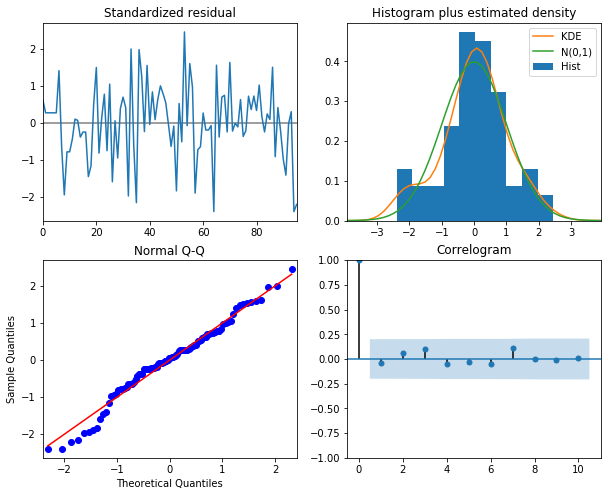

In [10]:
model.plot_diagnostics(figsize=(10, 8))
plt.show()

In the top left, the residual errors fluctuate around a mean of zero and have a uniform variance, which may indicate that there is no bias in prediction. The density plot in the top right suggests normal distribution with mean zero.

The Correlogram, or the ACF plot, in the lower right shows the residual errors are not autocorrelated. Any detected autocorrelation in this plot suggests that there may be some pattern in the residual errors which are not explained in the model, so adding additional predictors to the model may be beneficial.

In the bottom left, we do not see significant deviation of residuals from the red line, which indicates that the model is a good fit.

Overall, based on the above, it seems to that the model is a good fit for this data.


It is worth noting that selecting the best parameters for an ARIMA model can be challenging - somewhat subjective and time intesive, and should be done following a thorough data examination (seasonality, trend, bias). We use an `auto_arima()` function to search a provided space of parameters for the best model, mostly to demonstrate its usage and functionality.



## Model evaluation

Let's now take a look at the predictions. Since auto_arima model makes consecutive forecasts from the last time point, we want to forecast the next `n_periods = GAP + HORIZON - 1` points, so that we can account for the GAP, as described in the data setup. As mentioned above, we are also transforming our predictions from logarithmic scale to counts, for calculating evaluation metric.

In [11]:
preds = model.predict(n_periods=GAP + HORIZON - 1)

predictions = np.round(np.exp(preds[-HORIZON:]))
pred_df = pd.DataFrame({"predictions": predictions, "store": STORE, "brand": BRAND, "week": test_week_list})

pred_df

,predictions,store,brand,week
0,"2,204.00",2,6,137
1,"2,551.00",2,6,138


To evaluate the model, we will use *mean absolute percentage error* or **MAPE**.

In [12]:
# Combine actual units and predictions
test_ts = test_filled.loc[(test_filled.store == STORE) & (test_filled.brand == BRAND)]

combined = pd.merge(pred_df, test_ts, on=["store", "brand", "week"], how="left")
combined

,predictions,store,brand,week,actuals
0,"2,204.00",2,6,137,5760
1,"2,551.00",2,6,138,1440


In [13]:
metric_value = MAPE(combined.predictions, combined.actuals) * 100

print(f"MAPE of the forecasts is {metric_value} %")

MAPE of the forecasts is 69.44444444444444 %


## Model training for all stores and brands

Now let's run model training across all the stores and brands. We will re-run the same code to automatically search for the best parameters, simply wrapped in a for loop iterating over stores and brands.

Note that we will be using [Ray](https://ray.readthedocs.io/en/latest/#) to distribute the computation to the cores available on your machine if Ray is installed. Otherwise, we will train the models for different stores and brands sequentially. By the time we develop this example, Ray only supports Linux and MacOS. Thus, sequential training will be used on Windows. In the cells below, we first define a function that trains an ARIMA model for a specific store-brand. Then, we use the following to leverage Ray:
- `ray.init()` will start all the relevant Ray processes
- we define a function to run an ARIMA model on a single brand and single store. To turn this function into a function that can be executed remotely, we declare the function with the ` @ray.remote` decorator.
- `ray.get()` collects the results, and `ray.shutdown()` will stop Ray.

It will take around 2.5 minutes to run the below cell on a machine with 4 cores and about 1.6 minutes on a machine with 6 cores, respectively. If you would like to further reduce the run time, you can run the below code on a subset of stores, by setting the `STORE_SUBSET` parameter to `True` in the *Parameters* section on top. This will limit the modeling to the first 20 stores.

After Ray is initialized, you can monitor its resource utilization from [Ray dashboard](https://ray.readthedocs.io/en/latest/ray-dashboard.html). After running the following cell, you will see the URL of the dashboard like `'webui_url': 'localhost:8265'` in the printed address information. The default port of the Ray dashboard is 8265. If this port is taken, it will be launched from another port. You can directly access the dashboard through a web browser if you use a local machine. If you work with a remote VM, please do a port forwarding by executing
```
ssh -L 8265:localhost:8265 <user-name>@<ip-address-of-the-vm>
```
on your local machine before accessing the dashboard locally. Below is a snapshot of the Ray dashboard during a previous run of the notebook.

<img src="https://user-images.githubusercontent.com/20047467/77698387-e8304600-6f86-11ea-9b47-f456cc898c78.png">


In [14]:
def train_store_brand(data, store, brand):
    train_ts = data.loc[(data.store == store) & (data.brand == brand)]
    train_ts = np.array(train_ts["logmove"])

    model = auto_arima(
        train_ts,
        seasonal=params["seasonal"],
        start_p=params["start_p"],
        start_q=params["start_q"],
        max_p=params["max_p"],
        max_q=params["max_q"],
        stepwise=True,
        error_action="ignore",
    )

    model.fit(train_ts)
    preds = model.predict(n_periods=GAP + HORIZON - 1)
    predictions = np.round(np.exp(preds[-HORIZON:]))

    pred_df = pd.DataFrame({"predictions": predictions, "store": store, "brand": brand, "week": test_week_list})
    test_ts = test_filled.loc[(test_filled.store == store) & (test_filled.brand == brand)]

    return pd.merge(pred_df, test_ts, on=["store", "brand", "week"], how="left")

In [15]:
%%time

if module_exists("ray"):
    print("Ray is available. Parallel training will be used. \n")
    
    import ray
    import logging

    # Initialize Ray
    print("Initializing Ray...")
    address_info = ray.init(log_to_driver=False, logging_level=logging.ERROR)
    print("Address information about the processes started by Ray:")
    print(address_info, "\n")

    if STORE_SUBSET:
        store_list = store_list[0:20]

    @ray.remote
    def ray_train_store_brand(data, store, brand):
        return train_store_brand(data, store, brand)

    print("Training ARIMA model...")

    # Persist input data into Ray shared memory
    train_filled_id = ray.put(train_filled)

    # Train for each store/brand
    results = [
        ray_train_store_brand.remote(train_filled_id, store, brand)
        for store, brand in itertools.product(store_list, brand_list)
    ]

    result_df = pd.concat(ray.get(results), ignore_index=True)

    # Stop Ray
    ray.shutdown()

Ray is available. Parallel training will be used. 

Initializing Ray...
Address information about the processes started by Ray:
{'node_ip_address': '172.18.9.4', 'redis_address': '172.18.9.4:62767', 'object_store_address': '/tmp/ray/session_2020-03-30_16-49-09_880221_16552/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2020-03-30_16-49-09_880221_16552/sockets/raylet', 'webui_url': 'localhost:8265', 'session_dir': '/tmp/ray/session_2020-03-30_16-49-09_880221_16552'} 

Training ARIMA model...
CPU times: user 2.61 s, sys: 439 ms, total: 3.05 s
Wall time: 1min 38s


If Ray is not installed, we will train all the models sequentially as follows. The training time could be several times longer compared with training the models in parallel with Ray.

In [16]:
%%time

if not module_exists("ray"):
    print("Ray is not available. Sequential training will be used. \n")
    
    from datetime import datetime
    
    if STORE_SUBSET:
        store_list = store_list[0:10]

    result_df = pd.DataFrame(None, columns=["predictions", "store", "brand", "week", "actuals"])

    print("Training ARIMA model...")
    for store, brand in itertools.product(store_list, brand_list):

        if brand == 1:
            print(f"{datetime.now().time()} - Forecasting for store: {store}")

        combined_df = train_store_brand(train_filled, store, brand)
        result_df = result_df.append(combined_df, ignore_index=True)

CPU times: user 8.81 ms, sys: 8.15 ms, total: 17 ms
Wall time: 16.3 ms


Let's compute `MAPE` for all predictions.

In [17]:
metric_value = MAPE(result_df.predictions, result_df.actuals) * 100
sb.glue("MAPE", metric_value)

print(f"MAPE of the forecasts is {metric_value} %")

MAPE of the forecasts is 69.74494861298409 %


When building a model with `auto_arima` for a large number of time series, it is often difficult to examine each model individually (in a similar way we did for the single time series above). As `auto_arima` searches a restricted space of the models, defined by the range of `p` and `q` parameters, we often might not find an optimal model for each time series.

Let's plot a few examples of forecasted results.

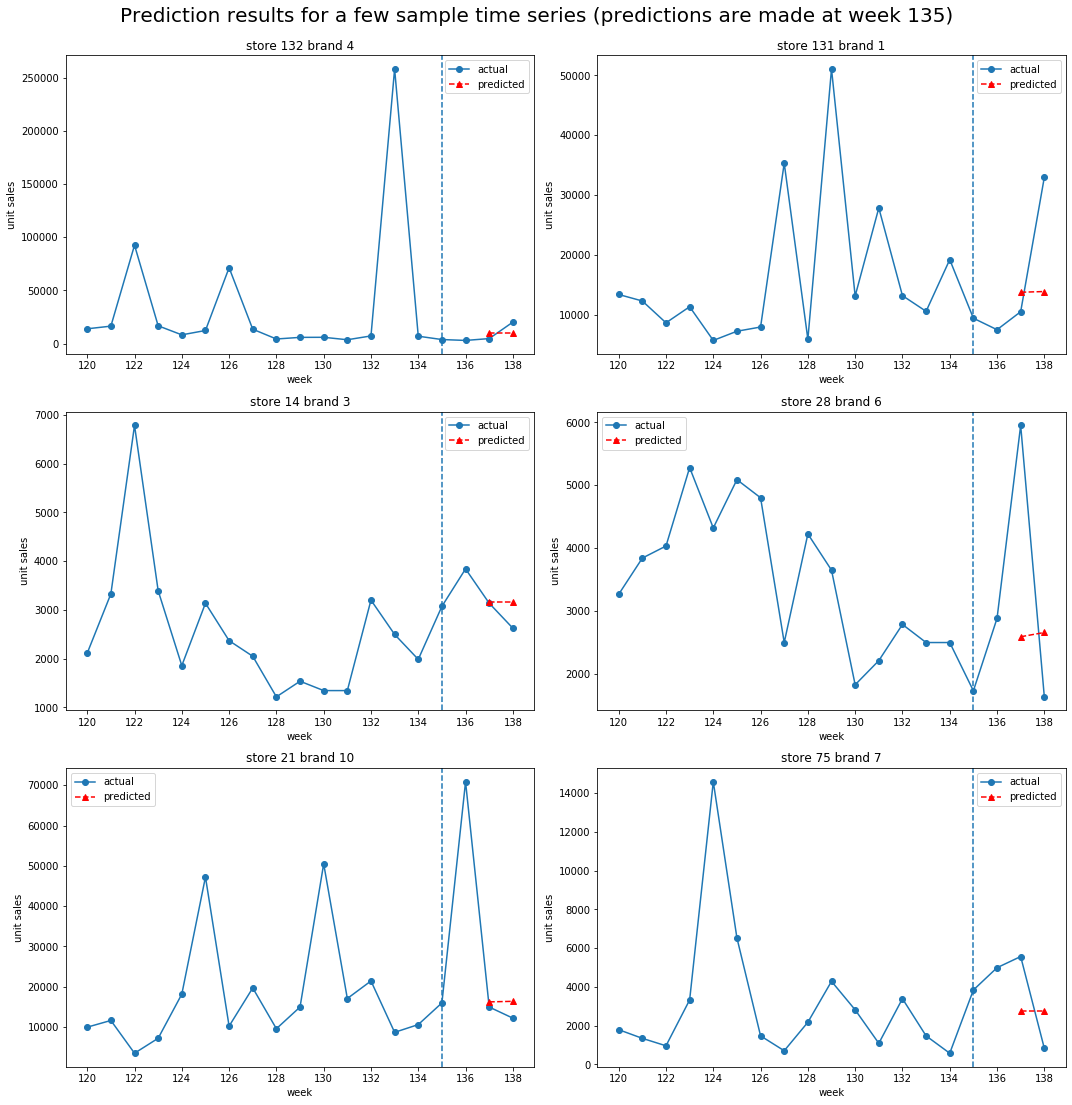

In [18]:
num_samples = 6
min_week = 120
sales = pd.read_csv(os.path.join(DATA_DIR, "yx.csv"))
sales["move"] = sales.logmove.apply(lambda x: round(math.exp(x)) if x > 0 else 0)

result_df["move"] = result_df.predictions
plot_predictions_with_history(
    result_df,
    sales,
    grain1_unique_vals=store_list,
    grain2_unique_vals=brand_list,
    time_col_name="week",
    target_col_name="move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=min_week,
    num_samples=num_samples,
    predict_at_timestep=max(train_df.week),
    line_at_predict_time=True,
    title="Prediction results for a few sample time series (predictions are made at week 135)",
    x_label="week",
    y_label="unit sales",
    random_seed=2,
)

## Additional Reading

\[1\] Rob J Hyndman and George Athanasopoulos. 2018. Forecasting: Principles and Practice. Chapter 8 ARIMA models: https://otexts.com/fpp2/arima.html <br>

\[2\] Modern Parallel and Distributed Python: A Quick Tutorial on Ray: https://rise.cs.berkeley.edu/blog/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray/ <br>